In [1]:
import folium
# USE THIS TERMINAL TO GET YOUR START AND END COORDINATES FOR IN THE CITY HERE 

# Create a Folium map centered on a specific location
m = folium.Map(location=[47.6062, -122.3321], zoom_start=12)

m.add_child(folium.LatLngPopup())
m

In [3]:
import folium
# INPUT LATITUDE LONGITUDE POINTS FOR THE ROUTER HERE, THEN CONFIRM THEM ON THE MAP. GREEN IS START PIONT, RED IS END
StartPointCoordinates = [47.5913,-122.2945]  #Input start chordinates here
EndPointCoordinates = [47.6124,-122.2958] #Inpute End Coordinates Here

# Create a Folium map centered on a specific location
m = folium.Map(location=[47.6062, -122.3321], zoom_start=11)

# Add a markers to the map
markerStart = folium.Marker(location=StartPointCoordinates, tooltip='Start', popup='start', draggable=True, icon=folium.Icon(color='green'))
markerStart.add_to(m)
markerEnd = folium.Marker(location=EndPointCoordinates, tooltip='End', popup='end', draggable=True, icon=folium.Icon(color='red'))
markerEnd.add_to(m)

# m.add_child(folium.LatLngPopup())
# Display the map
m

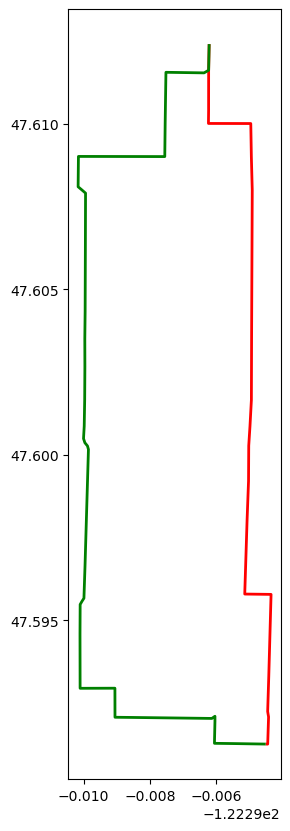

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import folium
from qgis.core import *
from qgis.gui import *
from qgis.analysis import *

from qgis.PyQt.QtCore import *
from qgis.PyQt.QtGui import *

# Setting up start and end points 
startPoint = QgsPointXY(markerStart.location[1],markerStart.location[0])
endPoint = QgsPointXY(markerEnd.location[1],markerEnd.location[0])

#setting up default router (only need one vector Layer, director StartPoint and EndPoint)
vectorLayer = QgsVectorLayer('SeattleNetwork.gpkg')
director = QgsVectorLayerDirector(vectorLayer, -1, '', '', '', QgsVectorLayerDirector.DirectionBoth)
strategy = QgsNetworkDistanceStrategy()
director.addStrategy(strategy)

builder = QgsGraphBuilder(vectorLayer.sourceCrs())

startPoint = QgsPointXY(markerStart.location[1],markerStart.location[0])
endPoint = QgsPointXY(markerEnd.location[1],markerEnd.location[0])

tiedPoints = director.makeGraph(builder, [startPoint, endPoint])
tStart, tStop = tiedPoints

graph = builder.graph()
idxStart = graph.findVertex(tStart)
idxEnd = graph.findVertex(tStop)

(tree, costs) = QgsGraphAnalyzer.dijkstra(graph, idxStart, 0)


if tree[idxEnd] == -1:
    raise Exception('No route!')

# Total cost
cost = costs[idxEnd]

# Add last point
route = [graph.vertex(idxEnd).point()]

# Iterate the graph
while idxEnd != idxStart:
    idxEnd = graph.edge(tree[idxEnd]).fromVertex()
    route.insert(0, graph.vertex(idxEnd).point())
    
# Check if the route has at least two points
if len(route) < 2:
    raise ValueError('Route has less than two points')

#--------------------------------------------------- Weighted Bike Router Speed5

#Setting up Router "Speed" 5 here: (this can go wrong)
vectorLayer5 = QgsVectorLayer('SeattleNetwork.gpkg')
director5 = QgsVectorLayerDirector(vectorLayer5, -1, '', '', '', QgsVectorLayerDirector.DirectionBoth)
speed_field_name5 = 'RoutingSp5'
# Get the index of the speed field
speed_field_index5 = vectorLayer5.fields().indexFromName(speed_field_name5)
# Set the speed units and conversion factor
speed_units5 = QgsUnitTypes.DistanceKilometers  # Adjust the units as needed
speed_conversion5 = 1.0  # Adjust the conversion factor as needed
strategy5 = QgsNetworkSpeedStrategy(speed_field_index5, speed_units5, speed_conversion5)
director5.addStrategy(strategy5)

builder5 = QgsGraphBuilder(vectorLayer5.sourceCrs())

#For Speed 5:
tiedPoints5 = director5.makeGraph(builder5, [startPoint, endPoint])
tStart5, tStop5 = tiedPoints5

#for Speed5:
graph5 = builder5.graph()
idxStart5 = graph5.findVertex(tStart5)
idxEnd5 = graph5.findVertex(tStop5)

(tree5, costs5) = QgsGraphAnalyzer.dijkstra(graph5, idxStart5, 0)

if tree5[idxEnd5] == -1:
    raise Exception('No route!')
    
cost5 = costs5[idxEnd5]  

# Add last point
route5 = [graph5.vertex(idxEnd5).point()]

# Iterate the graph
while idxEnd5 != idxStart5:
    idxEnd5 = graph5.edge(tree5[idxEnd5]).fromVertex()
    route5.insert(0, graph5.vertex(idxEnd5).point())
    
# Check if the route has at least two points
if len(route5) < 2:
    raise ValueError('Route has less than two points')

#------------------------------ CONVERSION STARTS
    
# Conversion for Speed 5:
route_coords5 = [(point.x(), point.y()) for point in route5]
route_line5 = LineString(route_coords5)
route_gdf5 = gpd.GeoDataFrame(geometry=[route_line5])

# Convert the route to a GeoPandas DataFrame
route_coords = [(point.x(), point.y()) for point in route]
route_line = LineString(route_coords)
route_gdf = gpd.GeoDataFrame(geometry=[route_line])

# Create the plot of the GeoDataFrame and basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the route_gdf on top
route_gdf.plot(ax=ax, color='red', linewidth=2)

# Plot route_gdf5 on top
route_gdf5.plot(ax=ax, color='green', linewidth=2)

# Display the plot (usefull for troubleshooting)
# plt.show()

# Displaying on folium
# Read the GeoDataFrames
route_gdf = gpd.GeoDataFrame.from_features(route_gdf, crs='EPSG:4326')

# Read the GeoDataFrames for Speed 5
route_gdf5 = gpd.GeoDataFrame.from_features(route_gdf5, crs='EPSG:4326')

# Convert the GeoDataFrames to GeoJSON
route_geojson = route_gdf.to_crs('EPSG:4326').to_json()

# Convert GeoDataFrame for Speed5 to GeoJson
route_geojson5 = route_gdf5.to_crs('EPSG:4326').to_json()

# Create a Folium map centered on Seattle
m = folium.Map(location=[47.6062, -122.3321], zoom_start=12)

# Add Speed 5 route GeoJSON to folium map
folium.GeoJson(route_geojson5, style_function=lambda x: {'color': 'green', 'weight': 2}).add_to(m)

# Add the route GeoJSON layer to the map
folium.GeoJson(route_geojson, style_function=lambda x: {'color': 'red', 'weight': 2, 'opacity': 0.5}).add_to(m)

# Display the map
m